# Load data

In [1]:
import parser
import pandas as pd

DATA = pd.DataFrame(parser.load_data("../non-pv-data/"))
DATA['install_date'] = pd.to_datetime(DATA['install_date']).dt.tz_localize(None)
DATA['removal_date'] = pd.to_datetime(DATA['removal_date']).dt.tz_localize(None)
WIND = DATA[DATA["energy_type"] == "Wind"]
print(f'Filtered entries: {len(WIND)}')

Entries loaded from files: 164208
Filtered entries: 39795


# Map

In [11]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
import matplotlib.pyplot as plt
from datetime import date, datetime
import warnings

# --- Path to your GeoPackage file ---
# Assuming 'germany_kreise.gpkg' now contains ALL desired administrative units
# (kreise AND city-states) in the 'multipolygons' layer.
gpkg_file_path = 'germany_kreise.gpkg' 

# --- Load the GeoPackage into a GeoDataFrame ---
germany_admin_units = None
germany_admin_units = gpd.read_file(gpkg_file_path, layer="multipolygons")
print(f"Successfully loaded {len(germany_admin_units)} administrative units from '{gpkg_file_path}'.")

# --- Removal Logic for "Nationalpark Hamburgisches Wattenmeer" (part_id 2) ---
hamburg_name = "Hamburg"
park_part_id_to_remove = 2 # Confirmed ID for "Nationalpark Hamburgisches Wattenmeer"

hamburg_row_index = germany_admin_units[germany_admin_units['name'] == hamburg_name].index

if not hamburg_row_index.empty:
    hamburg_geometry = germany_admin_units.loc[hamburg_row_index[0], 'geometry']

    if isinstance(hamburg_geometry, MultiPolygon):
        main_hamburg_parts = [
            geom for i, geom in enumerate(hamburg_geometry.geoms) 
            if i != park_part_id_to_remove
        ]

        if len(main_hamburg_parts) == 1:
            new_hamburg_geometry = main_hamburg_parts[0]
        elif len(main_hamburg_parts) > 1:
            new_hamburg_geometry = MultiPolygon(main_hamburg_parts)
        else:
            new_hamburg_geometry = None 
            print(f"Warning: All parts of '{hamburg_name}' removed. Check part_id.")
        
        if new_hamburg_geometry:
            germany_admin_units.loc[hamburg_row_index[0], 'geometry'] = new_hamburg_geometry
            print(f"Successfully removed part ID {park_part_id_to_remove} from '{hamburg_name}' MultiPolygon.")
        else:
            print(f"Failed to update '{hamburg_name}' geometry after part removal.")
    else:
        print(f"'{hamburg_name}' geometry is a single {type(hamburg_geometry).__name__}. No parts to remove.")
else:
    print(f"'{hamburg_name}' entry not found in the GeoDataFrame. No part removed.")
# --- End of Removal Logic ---

print("\nFirst 5 rows of the GeoDataFrame:")
print(germany_admin_units.head())
print("\nColumns available:", germany_admin_units.columns.tolist())
print("\nUnique 'admin_level' values:", germany_admin_units['admin_level'].unique())
print("\nNames of admin_level=4 entries (after potential modification):")
print(germany_admin_units[germany_admin_units['admin_level'] == '4']['name'].tolist())

Successfully loaded 402 administrative units from 'germany_kreise.gpkg'.
Successfully removed part ID 2 from 'Hamburg' MultiPolygon.

First 5 rows of the GeoDataFrame:
                          name admin_level        boundary  \
0    Kreis Schleswig-Flensburg           6  administrative   
1              Kreis Steinburg           6  administrative   
2  Kreis Rendsburg-Eckernförde           6  administrative   
3          Kreis Nordfriesland           6  administrative   
4                    Flensburg           6  administrative   

                                            geometry  
0  MULTIPOLYGON (((9.7409 54.82344, 9.74671 54.82...  
1  MULTIPOLYGON (((9.53086 54.09926, 9.53065 54.0...  
2  MULTIPOLYGON (((9.96535 54.6258, 9.96618 54.62...  
3  MULTIPOLYGON (((8.68713 54.5087, 8.68751 54.50...  
4  MULTIPOLYGON (((9.43777 54.82801, 9.44938 54.8...  

Columns available: ['name', 'admin_level', 'boundary', 'geometry']

Unique 'admin_level' values: ['6' '4']

Names of admin_level

# Plot map

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
import matplotlib.pyplot as plt
from datetime import date, datetime
import warnings
import mapclassify # Import for natural breaks
import matplotlib.colors as mcolors # For colormap normalization
import matplotlib.patches as mpatches # For creating custom legend patches

plt.rcParams['figure.dpi'] = 300

def plot_wind_power_by_county(plot_date: date, bins: list|float = None, save_plot = False):
    """
    Plots the total wind power on a map of Germany, aggregated by administrative unit (county)
    and including off-shore wind power represented by synthetic areas.

    Args:
        plot_date (date): The date for which to calculate and plot the total wind power.
        bins (list, optional): A list of bin edges for the color scale (e.g., [0, 10, 20, 30]).
                               If None, natural breaks (Jenks optimization) with 8 bins will be
                               calculated based on the data for the current plot_date.
                               For animation, it's recommended to pre-calculate and provide fixed bins.
        save_plot (bool): If True, saves the plot to a file instead of displaying it.

    Returns:
        list: The list of bin edges used for plotting. This can be reused for consistent
              coloring across multiple plots (e.g., in an animation).
    """
    # germany_admin_units and WIND are assumed to be globally available GeoDataFrames/DataFrames
    # as per the context of previous interactions.
    # The date columns in WIND (install_date, removal_date) are assumed to be pandas Timestamps
    # without timezone information.
    # WIND is also assumed to have an 'off_shore' column ('Nordsee', 'Ostsee', or None)

    if germany_admin_units is None or germany_admin_units.empty:
        print("Administrative data is not loaded or is empty. Cannot plot wind power.")
        return

    # Convert plot_date to pandas Timestamp for consistent comparison
    plot_date_ts = pd.Timestamp(plot_date)

    # Filter wind turbines active on the given date
    active_wind_turbines = WIND[
        (WIND["install_date"] <= plot_date_ts) &
        ((WIND["removal_date"].isna()) | (WIND["removal_date"] > plot_date_ts))
    ].copy()
    active_wind_turbines['power'] /= 1e6

    # --- Pre-process germany_admin_units to ensure a unique key for aggregation ---
    # We will work with a version of germany_admin_units that has a dedicated unique ID.
    # Assuming the original index of germany_admin_units is unique, we'll use that.
    # Create a copy and add a temporary 'unique_id' column if the index itself isn't what you want to join on.
    # Or, even simpler, use `reset_index()` to get a unique integer column.
    germany_admin_units_unique_id = germany_admin_units.reset_index().rename(columns={'index': 'unique_id'}).copy()


    # --- Create synthetic off-shore regions ---
    nordsee_x = 8.0
    nordsee_w = 0.5
    nordsee_y = 53.9
    nordsee_h = 0.3
    ostsee_x = 11.5
    ostsee_w = 0.5
    ostsee_y = 54.3
    ostsee_h = 0.3
    nordsee_poly = Polygon([(nordsee_x, nordsee_y + nordsee_h), (nordsee_x + nordsee_w, nordsee_y + nordsee_h), (nordsee_x + nordsee_w, nordsee_y), (nordsee_x, nordsee_y), (nordsee_x, nordsee_y + nordsee_h)])
    ostsee_poly = Polygon([(ostsee_x, ostsee_y + ostsee_h), (ostsee_x + ostsee_w, ostsee_y + ostsee_h), (ostsee_x + ostsee_w, ostsee_y), (ostsee_x, ostsee_y), (ostsee_x, ostsee_y + ostsee_h)])

    offshore_data = {
        'name': ["Nordsee", "Ostsee"],
        'admin_level': ["off_shore", "off_shore"],
        'geometry': [nordsee_poly, ostsee_poly],
        'unique_id': ["nordsee_offshore", "ostsee_offshore"] # Assign unique IDs for offshore
    }
    offshore_gdf = gpd.GeoDataFrame(offshore_data, crs=germany_admin_units.crs)
    
    # Combine original administrative units (with unique IDs) with off-shore polygons
    combined_admin_units = pd.concat([
        germany_admin_units_unique_id[['name', 'geometry', 'unique_id']], # Select only necessary columns
        offshore_gdf
    ], ignore_index=True)

    # Initialize a Series to hold aggregated power, indexed by 'unique_id'
    # This Series will be the source of truth for power values.
    # Initialize with zeros for all unique_ids in combined_admin_units.
    all_units_power_by_unique_id = pd.Series(0.0, index=combined_admin_units['unique_id'].values)
    unique_id_to_name_mapping = germany_admin_units_unique_id.set_index('unique_id')['name']
    # Separate land-based and off-shore wind turbines
    land_wind_turbines = active_wind_turbines[active_wind_turbines['off_shore'].isna()]
    offshore_nordsee_turbines = active_wind_turbines[active_wind_turbines['off_shore'] == 'Nordsee']
    offshore_ostsee_turbines = active_wind_turbines[active_wind_turbines['off_shore'] == 'Ostsee']
    print(f"--- Wind Turbine Statistics for {plot_date} ---")
    for name, df in [("Land-based", land_wind_turbines), ("Nordsee Off-shore", offshore_nordsee_turbines), ("Ostsee Off-shore", offshore_ostsee_turbines)]:
        if not df.empty:
            print(f"{name}: Total Turbines={len(df)}, Avg Power={df['power'].mean():.2f} GW, Max Power={df['power'].max():.2f} GW, Sum Power={df['power'].sum():.2f} GW")
        else:
            print(f"{name}: No active turbines found.")

    # Process land-based turbines via spatial join
    if not land_wind_turbines.empty:
        geometry_land = gpd.points_from_xy(land_wind_turbines['longitude'], land_wind_turbines['latitude'])
        land_wind_gdf = gpd.GeoDataFrame(land_wind_turbines, geometry=geometry_land, crs=germany_admin_units.crs)
        
        # Perform spatial join, get 'unique_id' from the right side
        land_joined = gpd.sjoin(
            land_wind_gdf,
            germany_admin_units_unique_id[['unique_id', 'geometry']], # Join with 'unique_id' and 'geometry'
            how="inner", # Use inner join to only keep turbines that successfully joined a polygon
            predicate="within"
        )
        
        if not land_joined.empty:
            # Aggregate total power by the unique ID of the administrative unit
            aggregated_land_power = land_joined.groupby('unique_id')['power'].sum()
            all_units_power_by_unique_id.update(aggregated_land_power)
        aggregated_land_count = land_joined.groupby('unique_id').size()
        # --- ADDED PRINT STATEMENT HERE ---
        print(f"\n--- Top 3 Land Counties by Wind Power for {plot_date} ---")
        # Filter out offshore unique_ids from combined_admin_units and then map to names
        land_power_series = all_units_power_by_unique_id.drop(labels=["nordsee_offshore", "ostsee_offshore"], errors='ignore')
        
        # Sort and get top 3, then map unique_id back to name for display
        top_3_land_counties = land_power_series.nlargest(3)
        
        # Check if top_3_land_counties is empty before trying to map
        if not top_3_land_counties.empty:
            for unique_id, power in top_3_land_counties.items():
                county_name = unique_id_to_name_mapping.get(unique_id, "Unknown County") # Use .get for safety
                turbine_count = aggregated_land_count.get(unique_id, 0)
                print(f"  {county_name}: {power:.2f} GW ({turbine_count} turbines)") # Changed GW to kW as per common units
        else:
            print("  No land counties with recorded wind power on this date.")

    
    # Aggregate off-shore wind power directly by their unique_id
    if not offshore_nordsee_turbines.empty:
        all_units_power_by_unique_id['nordsee_offshore'] += offshore_nordsee_turbines['power'].sum()
    
    if not offshore_ostsee_turbines.empty:
        all_units_power_by_unique_id['ostsee_offshore'] += offshore_ostsee_turbines['power'].sum()

    # Create a new GeoDataFrame for plotting by merging aggregated power back
    germany_admin_units_with_power = combined_admin_units.merge(
        all_units_power_by_unique_id.rename('total_wind_power'), # Rename Series for merge
        left_on='unique_id',
        right_index=True, # Merge on the index of the Series
        how='left'
    )
    
    # Fill any remaining NaNs (units with no power) with 0
    germany_admin_units_with_power['total_wind_power'] = germany_admin_units_with_power['total_wind_power'].fillna(0)

    # --- Determine bins for plotting ---
    # Define a small epsilon for floating point comparison with zero
    EPSILON = 1e-6 

    if type(bins) == float:
        fig, ax = plt.subplots(1, 1, figsize=(15, 15))
        # Determine vmin and vmax for the color scale
        plot_vmin = 0
        plot_vmax = bins
        # Check if plot_vmax is zero and adjust to avoid issues with colormap if all values are zero
        if plot_vmax == 0:
            plot_vmax = 1 # Set a small non-zero value if all power is zero

        germany_admin_units_with_power.plot(
            column='total_wind_power',
            cmap='viridis',  # Yellow-Green colormap
            linewidth=0.1,
            edgecolor='black',
            ax=ax,
            legend=True,  # This enables the colorbar
            legend_kwds={
                'label': "Windkraft (GW)",
                'orientation': "horizontal",
                'shrink': 0.6, # Keep shrink at 0.5 for now, adjust if needed later
                'pad': -0.02   # Increase pad to move the legend (colorbar) up from the bottom
            },
            vmin=plot_vmin, # Set fixed minimum
            vmax=plot_vmax, # Set fixed maximum
        )
        ax.set_title(f'Windkraft ({plot_date})', fontsize=18)
        ax.set_axis_off() # Remove axes
        if save_plot:
            plot_filename = f"fig/wind-linear-{plot_date.strftime('%Y-%m-%d')}.png"
            plt.savefig(plot_filename, dpi=fig.dpi, bbox_inches='tight', pad_inches=0.1)
            print(f"Saved plot to '{plot_filename}'")
            plt.close()
        else:
            plt.show() 
        return bins
    elif bins is None:
        # Calculate natural breaks if bins are not provided
        power_data = germany_admin_units_with_power['total_wind_power']
        
        # Ensure there's enough data variability for natural breaks to work
        if power_data.sum() > 0 and len(power_data.unique()) > 1:
            try:
                # Use NaturalBreaks with k=8 bins
                mb = mapclassify.NaturalBreaks(power_data, k=8)
                # plot_bins should include the minimum value as the first edge
                # mapclassify.NaturalBreaks.bins gives the upper bounds of the k bins.
                # The first bin's lower bound is the minimum value of the data.
                plot_bins = [power_data.min()] + mb.bins.tolist()
                # Ensure the first bin starts at 0 if the min value is very close to 0
                if abs(plot_bins[0]) < EPSILON:
                    plot_bins[0] = 0.0
            except ValueError as e:
                warnings.warn(f"Could not calculate natural breaks (Error: {e}). Using default bins [0, max_power]. "
                              "This might happen if data has too few unique values or is all zeros.")
                max_power = power_data.max()
                plot_bins = [0, max_power if max_power > 0 else 1] # Ensure at least 0 and a small positive value
        else:
            warnings.warn("Not enough unique wind power values for natural breaks. Using default bins [0, max_power].")
            max_power = power_data.max()
            plot_bins = [0, max_power if max_power > 0 else 1] # Default to 0 and 1 if all values are 0
    else:
        plot_bins = bins # Use provided bins

    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))

    germany_admin_units_with_power.plot(
        column='total_wind_power',
        cmap='viridis',  # Yellow-Green colormap
        linewidth=0.1,
        edgecolor='black',
        ax=ax,
        legend=False,  # Disable geopandas default colorbar
        scheme='UserDefined', # Use user-defined bins
        classification_kwds={'bins': plot_bins} # Pass the calculated or provided bins
    )

    ax.set_title(f'Windkraft ({plot_date})', fontsize=18)
    ax.set_axis_off() # Remove axes

    # --- Custom Legend ---
    # Get the colormap and create a normalization object for mapping data values to colors
    cmap = plt.cm.get_cmap('viridis')
    norm = mcolors.BoundaryNorm(plot_bins, cmap.N)

    patches = []
    labels = []

    # Loop through the bin edges to create labels and square patches
    # plot_bins has k+1 elements for k bins. We iterate k times.
    for i in range(len(plot_bins) - 1):
        lower_bound = plot_bins[i]
        upper_bound = plot_bins[i+1]

        # Format label as "lower-upper GW"
        label = f"{lower_bound:.2f}-{upper_bound:.2f} GW"
        
        # Get the color for this bin. Use the midpoint for color lookup.
        color = cmap(norm((lower_bound + upper_bound) / 2.0))
        
        # Create a square patch with the determined color
        patches.append(mpatches.Patch(color=color, label=label))
        labels.append(label)

    # Add the custom legend to the plot
    # loc='lower center' places the anchor point at the bottom center of the legend
    # bbox_to_anchor=(0.5, -0.25) positions this anchor point relative to the axes
    # (0,0 is bottom-left, 1,1 is top-right). Adjust -0.25 further down if needed.
    ax.legend(handles=patches, labels=labels, loc='lower center', ncol=4,
              bbox_to_anchor=(0.5, -0.02), title="", frameon=False, fontsize=10)

    # Adjust the subplot parameters to make space for the legend below the plot
    plt.subplots_adjust(bottom=0.25) # Increase bottom margin to accommodate the legend

    if save_plot:
        plot_filename = f"fig/wind-{plot_date.strftime('%Y-%m-%d')}.png"
        plt.savefig(plot_filename, dpi=fig.dpi, bbox_inches='tight', pad_inches=0.1)
        print(f"Saved plot to '{plot_filename}'")
        plt.close()
    else:
        plt.show()
    
    return plot_bins

--- Wind Turbine Statistics for 2025-07-01 ---
Land-based: Total Turbines=30027, Avg Power=0.00 GW, Max Power=0.01 GW, Sum Power=65.40 GW
Nordsee Off-shore: Total Turbines=1329, Avg Power=0.01 GW, Max Power=0.01 GW, Sum Power=7.39 GW
Ostsee Off-shore: Total Turbines=308, Avg Power=0.01 GW, Max Power=0.01 GW, Sum Power=1.83 GW

--- Top 3 Land Counties by Wind Power for 2025-07-01 ---
  Kreis Nordfriesland: 2.46 GW (847 turbines)
  Kreis Dithmarschen: 2.33 GW (831 turbines)
  Uckermark: 1.70 GW (670 turbines)


C:\Users\Paul\AppData\Local\Temp\ipykernel_32268\880309089.py:241: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis')


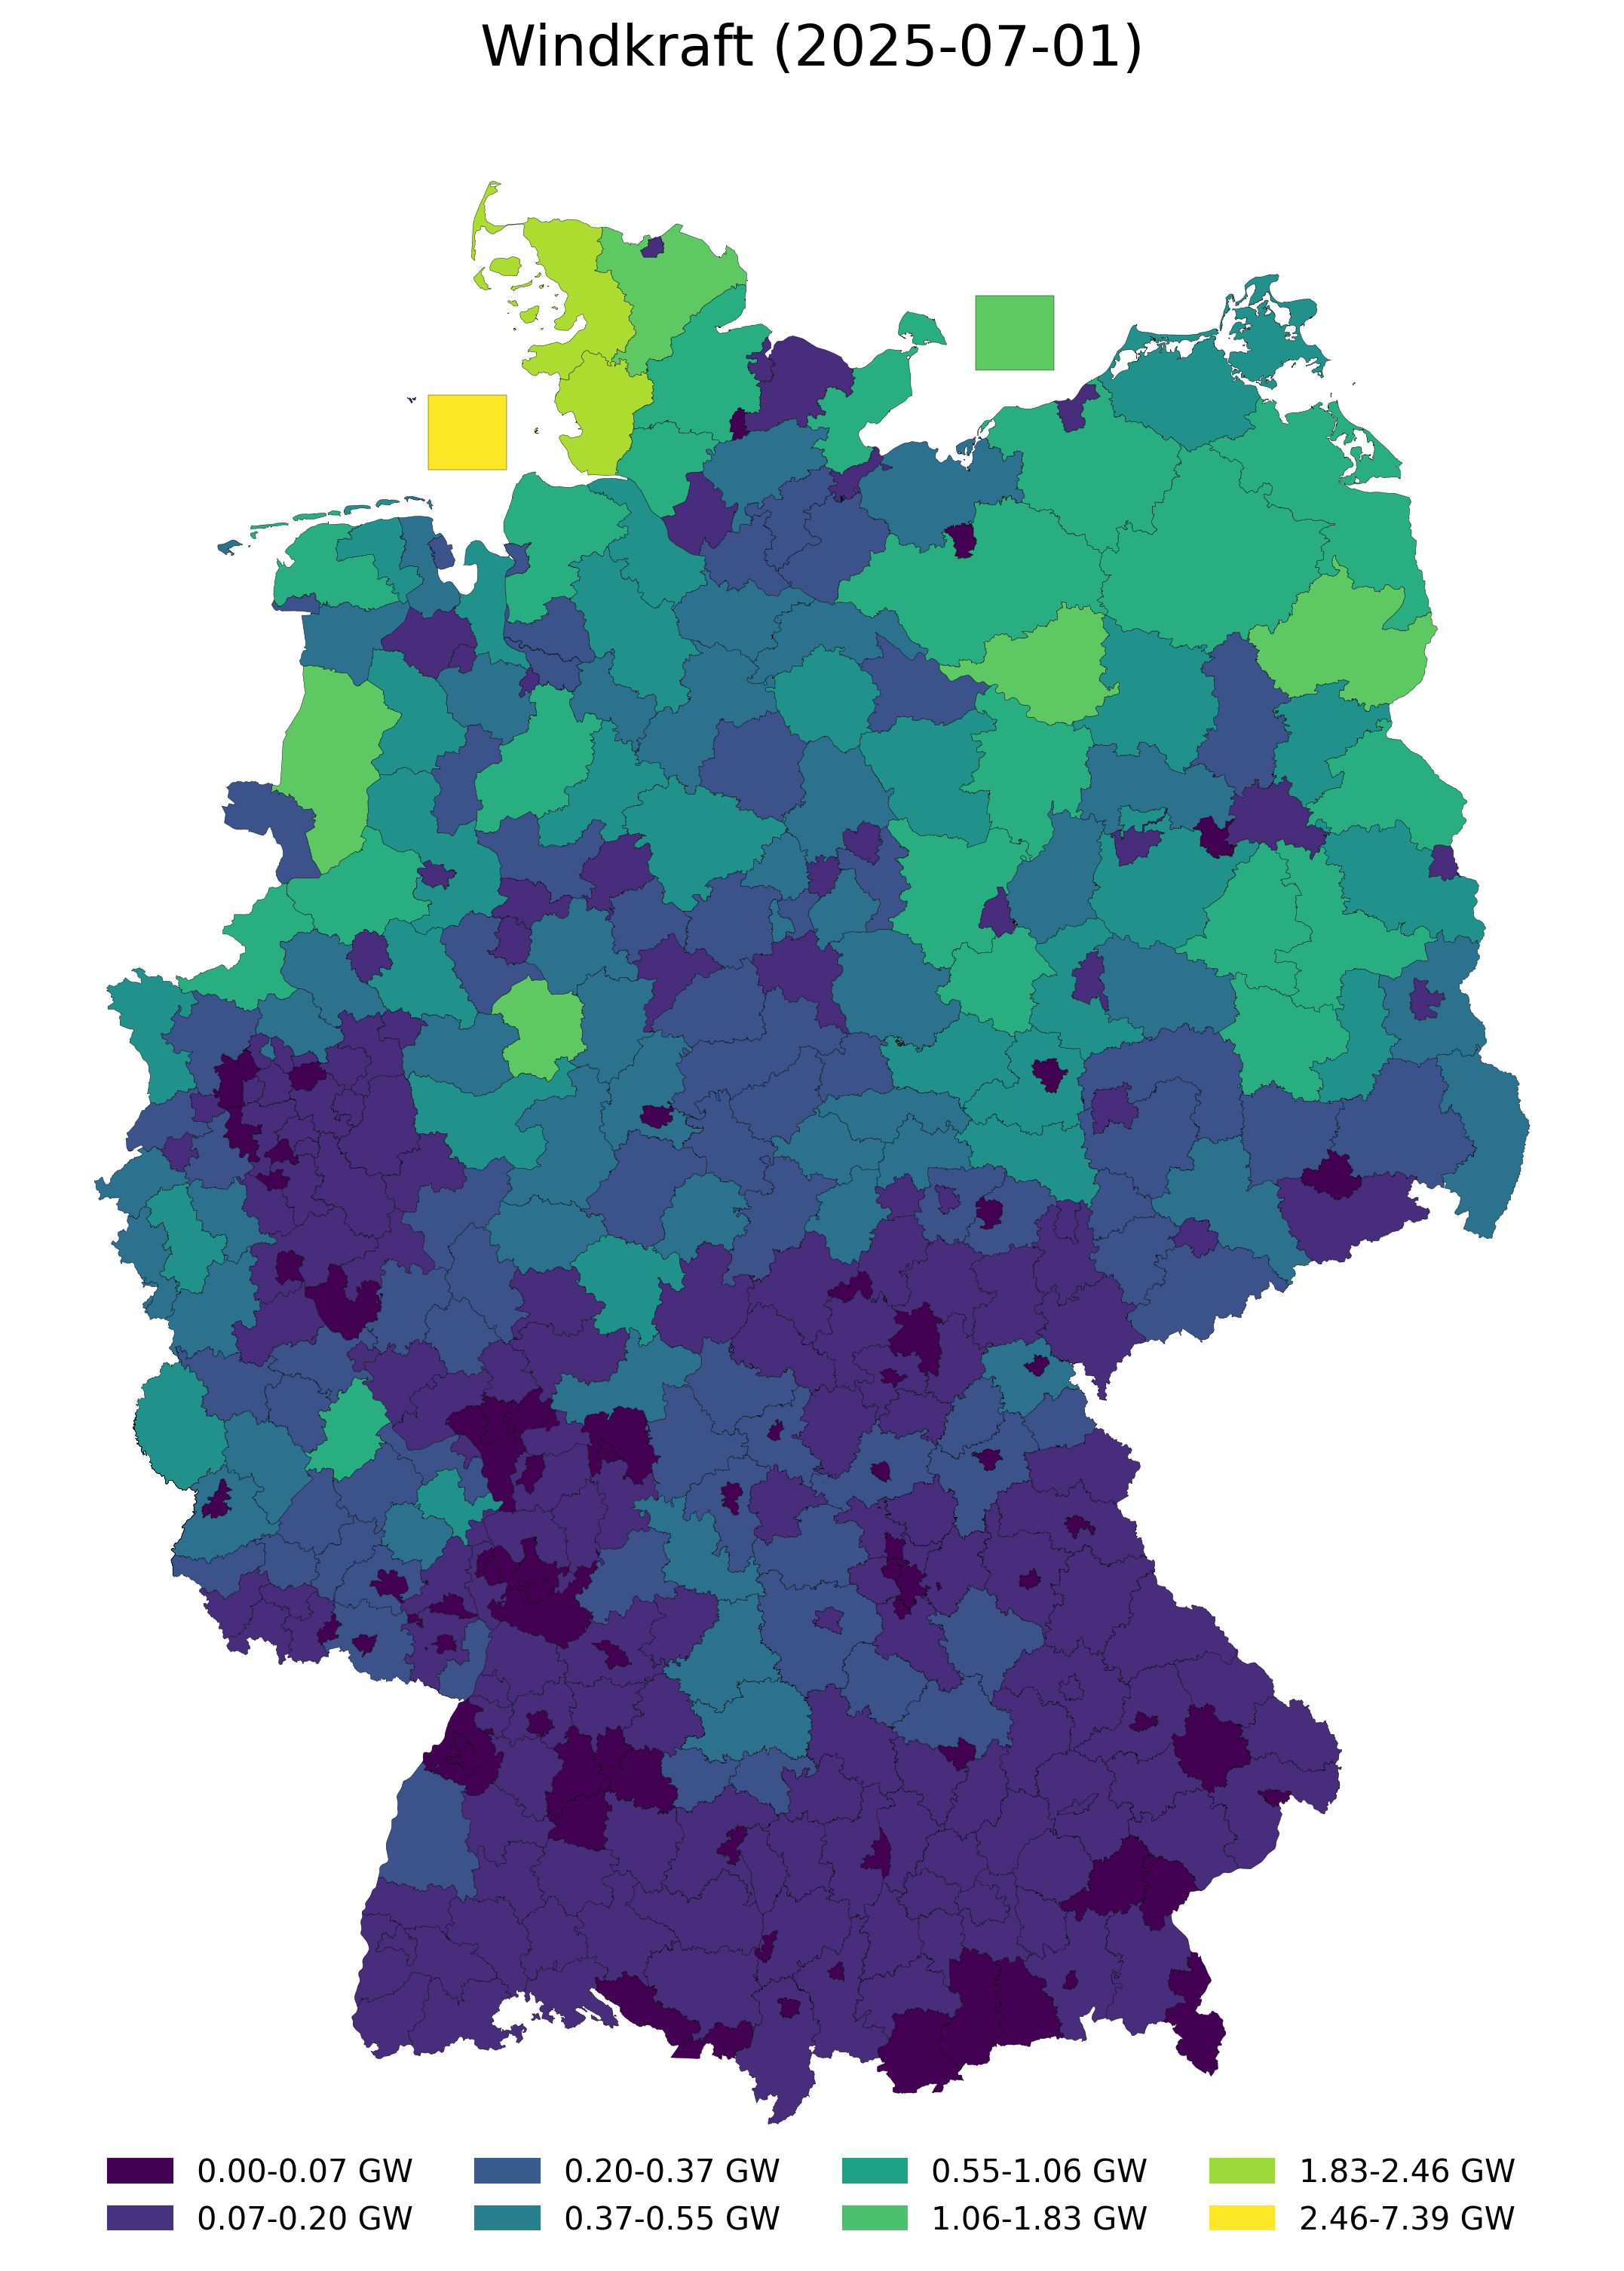

In [13]:
BINS = plot_wind_power_by_county("2025-07-01")

In [118]:
start_date = date(2000, 1, 1)

# --- End Date for the loop (Today's Date) ---
end_date = date.today()

# Generate dates for the 1st of every month
current_date_iter = start_date
while current_date_iter <= end_date:
    # Call your plotting function
    plot_wind_power_by_county(
        current_date_iter,
        BINS,
        save_plot=True,
    )
    # Move to the first day of the next month
    # This robustly handles month transitions and leap years
    if current_date_iter.month == 12:
        current_date_iter = date(current_date_iter.year + 1, 1, 1)
    else:
        current_date_iter = date(current_date_iter.year, current_date_iter.month + 1, 1)


--- Wind Turbine Statistics for 2000-01-01 ---
Land-based: Total Turbines=3740, Avg Power=0.00 GW, Max Power=0.00 GW, Sum Power=2.37 GW
Nordsee Off-shore: No active turbines found.
Ostsee Off-shore: No active turbines found.

--- Top 3 Land Counties by Wind Power for 2000-01-01 ---
  Landkreis Cuxhaven: 0.13 GW (209 turbines)
  Vorpommern-Greifswald: 0.08 GW (107 turbines)
  Kreis Steinburg: 0.07 GW (56 turbines)
Saved plot to 'fig/wind-linear-2000-01-01.png'
--- Wind Turbine Statistics for 2000-02-01 ---
Land-based: Total Turbines=3834, Avg Power=0.00 GW, Max Power=0.00 GW, Sum Power=2.47 GW
Nordsee Off-shore: No active turbines found.
Ostsee Off-shore: No active turbines found.

--- Top 3 Land Counties by Wind Power for 2000-02-01 ---
  Landkreis Cuxhaven: 0.13 GW (212 turbines)
  Vorpommern-Greifswald: 0.08 GW (107 turbines)
  Landkreis Aurich: 0.07 GW (155 turbines)
Saved plot to 'fig/wind-linear-2000-02-01.png'
--- Wind Turbine Statistics for 2000-03-01 ---
Land-based: Total Turbi